In [15]:
#%% Cell 1: Imports and Setup
import os

# List of required packages
required_packages = {
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'chardet': 'chardet'
}

# Check and install missing packages
for package, import_name in required_packages.items():
    try:
        __import__(import_name)
    except ImportError:
        print(f"Installing {package}...")
        !pip install {package}

# Now import all required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

from infer_data_type import EnhancedSalesforceValidator

# Display settings for better output readability
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_colwidth', None)



In [16]:
#%% Cell 2: Data Loading and Preparation
def load_data(file_path):
    """Load data with proper encoding detection"""
    try:
        return pd.read_csv(file_path)
    except UnicodeDecodeError:
        try:
            with open(file_path, 'rb') as f:
                encoding = chardet.detect(f.read(100000))['encoding']
            return pd.read_csv(file_path, encoding=encoding)
        except:
            return pd.read_csv(file_path, encoding='latin1')

# Path to your CSV
file_path = os.path.join("..", "csv_files", "extract.csv")

try:
    df = load_data(file_path)
    print("Dataset Overview:")
    print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
    print("\nSample of data:")
    print(df.head())
    
except FileNotFoundError:
    print(f"Error: Could not find file at {file_path}")
    print("Please check the file path and ensure the CSV file exists.")
    df = None
except Exception as e:
    print(f"Error loading data: {str(e)}")
    print("Please check the file path and file format.")
    df = None



Dataset Overview:
Rows: 11712, Columns: 251

Sample of data:
   AccountNumber    AccountSource  \
0        45633.0        Cold Call   
1        45336.0        Cold Call   
2        45583.0        Cold Call   
3        45897.0  Outside Company   
4        45895.0        Cold Call   

                                                                Account_Inactive_Details__c  \
0                                                                                       NaN   
1                                             Circle K has created their own pizza program.   
2                                 The entire chain has changed to a different pizza program   
3  Circle K decided to pull the Pizza but not replace it. Kitchen wasn't supporting itself.   
4                                 The entire chain has changed to a different pizza program   

                   Account_Inactive_Reasons__c Account_Sold_By__c  \
0                                          NaN          ADAM HUNT   
1  Exis

/tmp/ipykernel_764070/2406773628.py:12: DtypeWarning: Columns (63,76,83,108,109,113,128,138,147,161,162,187,189,212,244) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, encoding='latin1')


In [19]:
#%% Cell 3: Field Analysis
if df is not None:
    # Initialize the validator
    validator = EnhancedSalesforceValidator()
    
    # Analyze each field individually
    analysis_results = {}
    for column in df.columns:
        try:
            analysis_results[column] = validator.analyze_field(column, df[column])
        except Exception as e:
            print(f"Error analyzing column {column}: {str(e)}")
    
    # Create report dataframe
    report_data = []
    for field_name, analysis in analysis_results.items():
        report_data.append({
            "Field Name": field_name,
            "Suggested Type": analysis.suggested_type,
            "Confidence": f"{analysis.confidence:.2%}",
            "Unique Ratio": f"{analysis.unique_ratio:.2%}",
            "Null Ratio": f"{analysis.null_ratio:.2%}",
            "Sample Values": ", ".join(str(x) for x in analysis.sample_values[:3]),
            "Validation Pattern": analysis.validation_pattern
        })
    
    report_df = pd.DataFrame(report_data)
    print("\nField Analysis Report:")
    print(report_df)



/home/themba/dev/salesforce-cli-service/python_src/infer_data_type.py:119: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  and pd.to_datetime(non_null_values, errors="coerce").notna().mean()
/home/themba/dev/salesforce-cli-service/python_src/infer_data_type.py:119: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  and pd.to_datetime(non_null_values, errors="coerce").notna().mean()
/home/themba/dev/salesforce-cli-service/python_src/infer_data_type.py:119: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  and pd.to_datetime(non_null_values, errors="coerce").notna().mean()
/home/themba/


Field Analysis Report:
                                 Field Name Suggested Type Confidence  \
0                             AccountNumber         Number    120.00%   
1                             AccountSource           Text    100.00%   
2               Account_Inactive_Details__c      Text Area    124.33%   
3               Account_Inactive_Reasons__c           Text    100.00%   
4                        Account_Sold_By__c           Text    100.00%   
..                                      ...            ...        ...   
246   of_employees_dedicated_to_the_deli__c         Number    120.00%   
247      of_employees_usually_at_counter__c         Number    120.00%   
248  of_years_owner_s_has_owned_location__c         Number    120.00%   
249       of_years_owner_s_has_run_store__c         Number    120.00%   
250                sma__MAAssignmentRule__c           Text    100.00%   

    Unique Ratio Null Ratio  \
0         99.98%     26.99%   
1          0.13%      0.03%   
2     

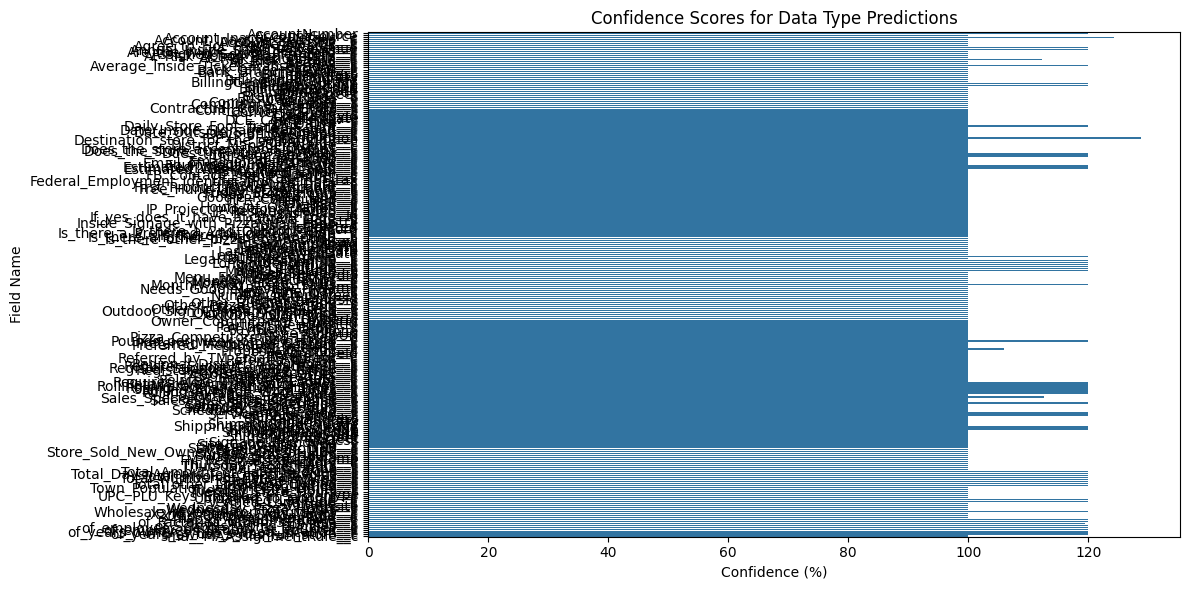

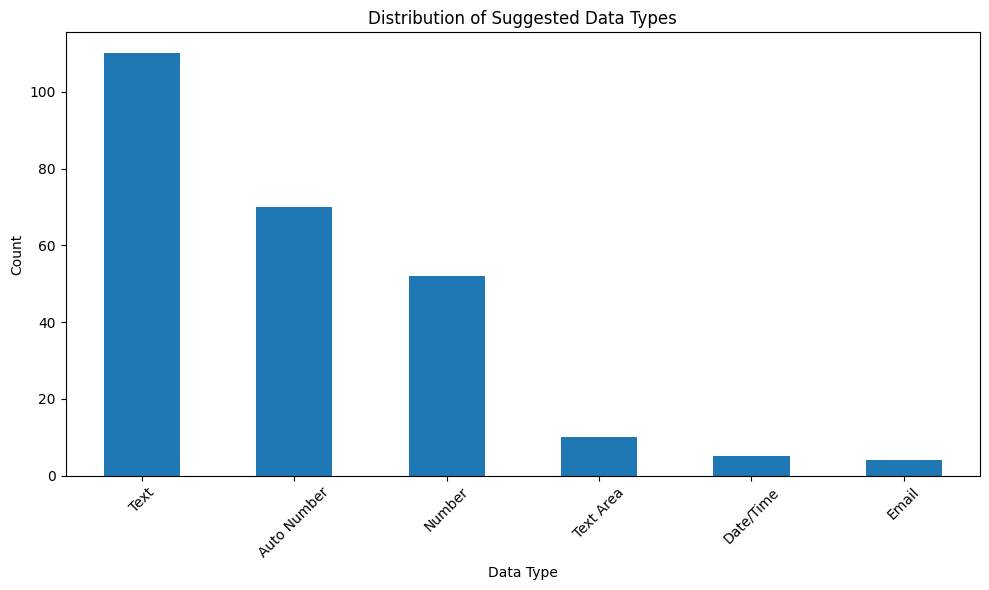

In [20]:
#%% Cell 4: Visualization of Results
def plot_confidence_scores(report_df):
    """Plot confidence scores for type predictions"""
    plt.figure(figsize=(12, 6))
    confidence_values = report_df['Confidence'].str.rstrip('%').astype(float)
    
    sns.barplot(x=confidence_values, y=report_df['Field Name'])
    plt.title('Confidence Scores for Data Type Predictions')
    plt.xlabel('Confidence (%)')
    plt.tight_layout()
    plt.show()

def plot_type_distribution(report_df):
    """Plot distribution of suggested types"""
    plt.figure(figsize=(10, 6))
    type_counts = report_df['Suggested Type'].value_counts()
    type_counts.plot(kind='bar')
    plt.title('Distribution of Suggested Data Types')
    plt.xlabel('Data Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if 'report_df' in locals():
    # Generate visualizations
    plot_confidence_scores(report_df)
    plot_type_distribution(report_df)



In [21]:
#%% Cell 5: Pattern Matching Analysis
def analyze_pattern_matches(df, analysis_results):
    """Analyze how well each field matches its suggested pattern"""
    pattern_analysis = {}
    
    for field, analysis in analysis_results.items():
        if analysis.validation_pattern and field in df.columns:
            # Get non-null values
            valid_data = df[field].dropna().astype(str)
            if len(valid_data) == 0:
                continue
                
            # Check pattern matches
            matches = valid_data.str.match(analysis.validation_pattern, na=False)
            match_ratio = matches.mean() if len(matches) > 0 else 0
            
            # Store results
            pattern_analysis[field] = {
                'suggested_type': analysis.suggested_type,
                'match_ratio': match_ratio,
                'total_values': len(valid_data),
                'matching_values': int(matches.sum()),
                'non_matching_examples': valid_data[~matches].head(3).tolist()
            }
    
    return pd.DataFrame.from_dict(pattern_analysis, orient='index')

if df is not None and 'analysis_results' in locals():
    pattern_analysis_df = analyze_pattern_matches(df, analysis_results)
    print("\nPattern Matching Analysis:")
    print(pattern_analysis_df)




Pattern Matching Analysis:
                                       suggested_type  match_ratio  \
AccountNumber                                  Number     1.000000   
AccountSource                                    Text     1.000000   
Account_Inactive_Details__c                 Text Area     0.943318   
Account_Inactive_Reasons__c                      Text     1.000000   
Account_Sold_By__c                               Text     1.000000   
...                                               ...          ...   
of_Schools_within_3_miles__c                   Number     1.000000   
of_employees_dedicated_to_the_deli__c          Number     1.000000   
of_employees_usually_at_counter__c             Number     1.000000   
of_years_owner_s_has_owned_location__c         Number     1.000000   
of_years_owner_s_has_run_store__c              Number     1.000000   

                                        total_values  matching_values  \
AccountNumber                                   8551      

In [12]:
#%% Cell 6: Export Results
def export_results(report_df, pattern_analysis_df, output_dir="analysis_output"):
    """Export analysis results to CSV files"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Export main report
    report_df.to_csv(os.path.join(output_dir, "field_type_analysis.csv"), index=False)
    
    # Export pattern analysis
    pattern_analysis_df.to_csv(os.path.join(output_dir, "pattern_matching_analysis.csv"))
    
    print(f"\nResults exported to {output_dir}/")

if all(var in locals() for var in ['report_df', 'pattern_analysis_df']):
    export_results(report_df, pattern_analysis_df)

#%% Cell 7: Interactive Pattern Testing
def test_pattern(df, field_name, pattern):
    """Test a custom pattern against a specific field"""
    if field_name not in df.columns:
        return "Field not found in dataset"
    
    valid_data = df[field_name].dropna().astype(str)
    matches = valid_data.str.match(pattern, na=False)
    
    return {
        'match_ratio': matches.mean() if len(matches) > 0 else 0,
        'total_values': len(valid_data),
        'matching_values': int(matches.sum()),
        'non_matching_examples': valid_data[~matches].head(3).tolist()
    }

# Example usage:
# if df is not None:
#     test_results = test_pattern(df, 'email_field', r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$')
#     print(test_results)